## Analyzing full sweep: sub4, n=4

In [27]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import gvar as gv
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import lsqfit # WARNING: lsqfit 12.0 appears to be broken. `python3 -m pip install lsqfit==11.8`

from z2_sim.src.NumericsPython.Analysis.fourieranalysis import fourier_ana
from z2_sim.src.QuantumCircuits.Cirq_Code import io

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### The data management is yucky.

But you already know that by now. See `noise_analysis_sub3`

In [29]:
noiseless_directory = "./results/noiseless"
flag = 'obc'
ns = [4]

# Load the noiseless data into a single dictionary that can be passed to `fourier_ana`
noiseless_data = {}
noiseless_tag = "control"


dts = [0.25]


for n in ns:
    noiseless_subdirectory = os.path.join(noiseless_directory, f"{n}/")
    noiseless_fname = f'noiseless_parameter_sweep_{noiseless_tag}_results_n{n}_{flag}.npy'
    arr = np.load(os.path.join(noiseless_subdirectory, noiseless_fname))[:,:,:50,:,:]
    noiseless_data[(flag, n)] = arr

# Submission card
dt = 0.25
j_sweep = np.asarray([0.714285, 0.625, .555556])
zeta_sweep = [0, 150000, 300000, 450000, 600000, 750000]
eps_sweep = [0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003]
n_trajectories = 1000
tstart = 1
tstop = 51
nprocs = 1

        
        
# assert statements never hurt anyone
j_sweep_control = np.load( os.path.join(noiseless_directory, io.make_physical_params_sweep_fname(noiseless_tag, 'jcoup')))
assert np.allclose(j_sweep, j_sweep_control, atol=1e-5, rtol=1e-4)

noisy_directory = './results/noisy'
beta_sweep = 1 / j_sweep
assert np.allclose(beta_sweep, [1.4, 1.6, 1.8])
beta_sweep = [1.4, 1.6, 1.8]
beta_keys = np.round(beta_sweep, decimals=6)


# # Load the data into separate dictionaries that can be passed to `fourier_ana`
# # This way, any element of this data sequence can be treated on equal footing 
# # with a noiseless data array.
noisy_data_grid = [[{} for _ in range(len(eps_sweep))] for _ in range(len(zeta_sweep))]

for n in ns:
    noisy_subdirectory = os.path.join(noisy_directory, f"{n}/")
    collector = io.CondorCollector(
        path=noisy_subdirectory,
        nprocs=nprocs,
        n=n,
        j_sweep=j_sweep,
        dt_sweep=[dt],
        trotter_intervals=[(tstart, tstop)],
        zeta_sweep=zeta_sweep,
        eps_sweep=eps_sweep, # don't look for eps=0
        r=n_trajectories,
    )

    #!! epsilon dependence stored in the 4th index
    #!! shot dependence stored in the 0th index
    data_arr = collector.collect_htcondor_outputs()
    for i in range(len(zeta_sweep)):
        for j in range(len(eps_sweep)):
            # (nprocs, len(j_sweep), len(dt_sweep), len(zeta_sweep), len(eps_sweep), trotter_steps, n, n)
            noisy_data_grid[i][j][('obc', n)] = data_arr[:,:,:,i,j,:,:,:].mean(axis=0)


#### Verify that noisy results are seeded differently!

The fact that the plot below has many lines means that each noisy simulation was different. This was a concern of mine that seeds might get duplicated during the condor submission process.

### Perform the fourier analysis and mass analysis on each dataset

Noiseless datset followed by noisy dataset at each noise parameter.

In [32]:
import qsimcirq

In [33]:
qsimcirq.__dict__

{'__name__': 'qsimcirq',
 '__doc__': None,
 '__package__': 'qsimcirq',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x7fc1585a4ef0>,
 '__spec__': ModuleSpec(name='qsimcirq', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7fc1585a4ef0>, origin='/mnt/c/Users/peter/Desktop/projects/Z2Sim/z2sim/lib/python3.6/site-packages/qsimcirq/__init__.py', submodule_search_locations=['/mnt/c/Users/peter/Desktop/projects/Z2Sim/z2sim/lib/python3.6/site-packages/qsimcirq']),
 '__path__': ['/mnt/c/Users/peter/Desktop/projects/Z2Sim/z2sim/lib/python3.6/site-packages/qsimcirq'],
 '__file__': '/mnt/c/Users/peter/Desktop/projects/Z2Sim/z2sim/lib/python3.6/site-packages/qsimcirq/__init__.py',
 '__cached__': '/mnt/c/Users/peter/Desktop/projects/Z2Sim/z2sim/lib/python3.6/site-packages/qsimcirq/__pycache__/__init__.cpython-36.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; E

In [30]:
bc_flags = ['obc']
noiseless_fourier = fourier_ana(
    results=noiseless_data, 
    bc_flags=bc_flags, 
    grid_sizes=ns, 
    dts=dts, 
    betas=beta_sweep, 
    n_trotter=50, 
    samp_rate = 2048, 
    nboot = 200)

noisy_fourier_grid = [[None for _ in range(len(eps_sweep))] for _ in range(len(zeta_sweep))]
for i in range(len(zeta_sweep)):
    for j in range(len(eps_sweep)):
        noisy_data = noisy_data_grid[i][j]
        noisy_fourier = fourier_ana(
            results=noisy_data, 
            bc_flags=bc_flags, 
            grid_sizes=ns, 
            dts=dts, 
            betas=beta_sweep, 
            n_trotter=50, 
            samp_rate = 2048, 
            nboot = 200
        )
        noisy_fourier_grid[i][j] = noisy_fourier


In [31]:
noisy_data_grid[-1][2][('obc', n)][2, 0,:,1,1].real

array([-0.00313195, -0.0140401 , -0.00889023,  0.00958334,  0.04327429,
        0.08768824,  0.08817755,  0.06185653,  0.0596467 ,  0.04141092,
       -0.02103299, -0.05503535, -0.0632517 , -0.05312574, -0.02602391,
        0.00027676,  0.02955145,  0.04811691,  0.055523  ,  0.05487563,
        0.04714958,  0.0395172 ,  0.03993411,  0.03976699,  0.04128091,
        0.04201335,  0.04095262,  0.03817335,  0.03462992,  0.02742291,
        0.02026371,  0.01384611,  0.01048477,  0.01076399,  0.01380767,
        0.01546266,  0.01824062,  0.01967485,  0.02085831,  0.02171018,
        0.02196867,  0.02095987,  0.02029525,  0.01850235,  0.01839111,
        0.01592567,  0.01629693,  0.01583654,  0.01531071,  0.01478879])

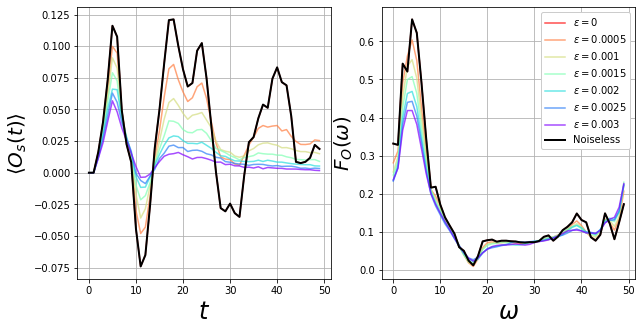

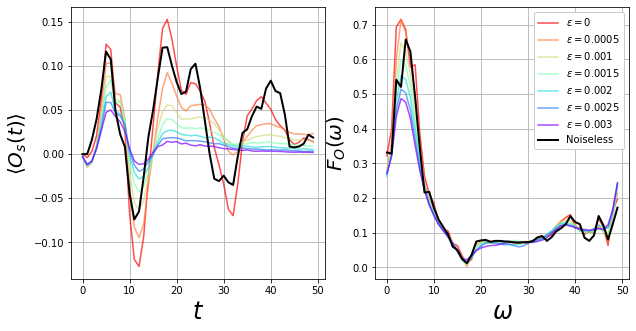

In [15]:
import matplotlib.cm as cm

colors = list(reversed([x for x in cm.rainbow(np.linspace(0, 1, len(eps_sweep) )) ]))
k = 2
beta = beta_sweep[k]
trotter_steps = 50
for zeta_idx in [0, -1]:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Plot time series
    # axes: [beta, dt, trotter_step, n, n]
    # slice for dt=0.25, and keep only beta in [1.4, 1.6, 1.8]
    for i, eps in enumerate(eps_sweep):
        y = noisy_data_grid[zeta_idx][i][('obc', n)][k, 0,:,1,1].real
        axes[0].plot(range(trotter_steps), y, label=f'{eps}', c=colors[i], alpha=0.7)    
    # Plot spectrum
    for i, eps in enumerate(eps_sweep):
        y = noisy_fourier_grid[zeta_idx][i][0][('obc', n, 0.25, beta)]
        axes[1].plot(range(trotter_steps), y, label=r"$\epsilon=$" + f'{eps}', c=colors[i], alpha=0.7)

    axes[0].plot(noiseless_data[('obc', n)][k, 0,:,1,1].real, label="Noiseless", c='k', lw=2)
    axes[1].plot(noiseless_fourier[0][('obc', n, 0.25, beta)], label="Noiseless", c='k', lw=2)

    axes[0].set_ylabel(r"$\langle O_s(t) \rangle$", size=20)
    axes[0].set_xlabel(r"$t$", size=24)
    axes[1].set_xlabel(r"$\omega$", size=24)
    axes[1].set_ylabel(r"$F_O(\omega) $", size=20)

    axes[1].legend(bbox_to_anchor=(1.0, 1), framealpha=1)
    for ax in axes:
        ax.grid()
# fig.savefig("../figures/sample_epsilon_timeseries.pdf")
    

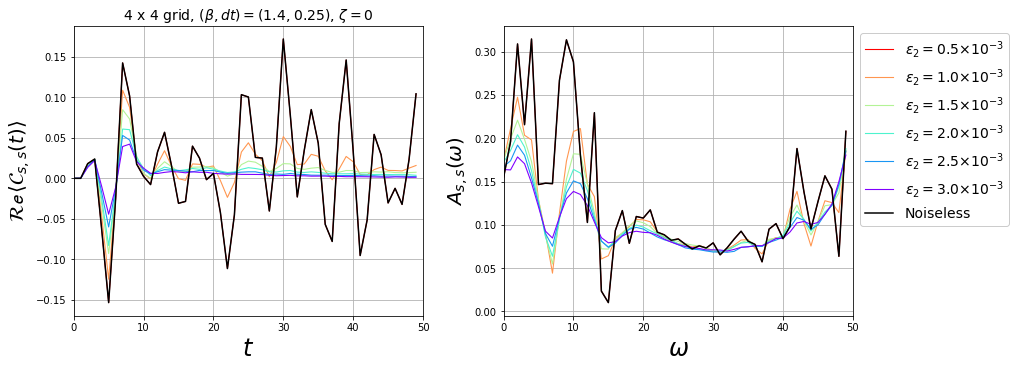

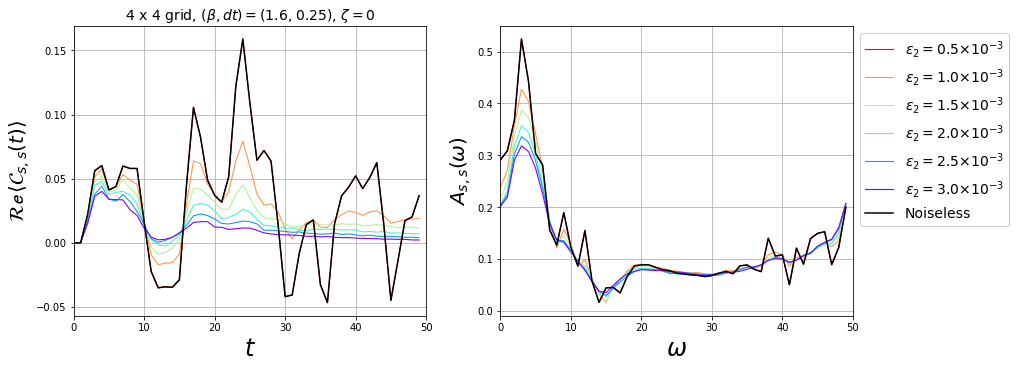

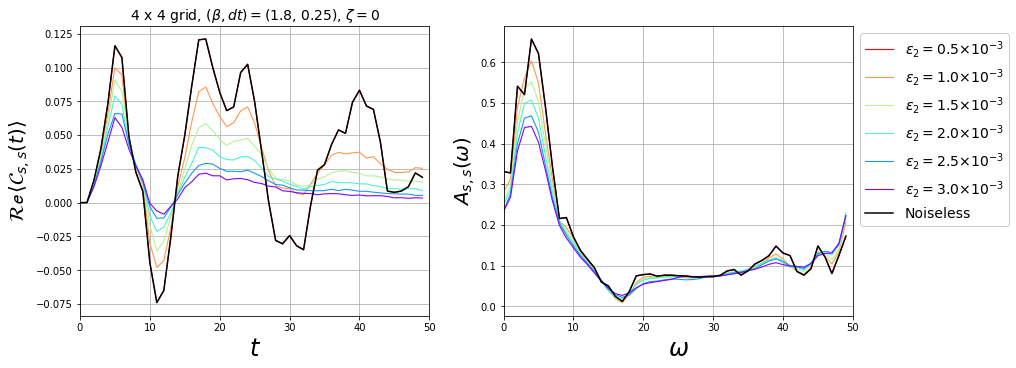

In [81]:
import matplotlib.cm as cm

colors = list(reversed([x for x in cm.rainbow(np.linspace(0, 1, len(eps_sweep) -1 )) ]))
for k in range(3):
#     k = 0
    beta = beta_sweep[k]
    trotter_steps = 50
    zeta_idx = 0


    fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
    # Plot time series
    # axes: [beta, dt, trotter_step, n, n]
    # slice for dt=0.25, and keep only beta in [1.4, 1.6, 1.8]
    for i, eps in enumerate(eps_sweep[1:]):
        y = noisy_data_grid[zeta_idx][i][('obc', n)][k, 0,:,1,1].real
        lab = r"$\epsilon_2=$" + f"{eps * 10**3}" + r"$\times 10^{-3}$"
        axes[0].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)    
    # Plot spectrum
    for i, eps in enumerate(eps_sweep[1:]):
        y = noisy_fourier_grid[zeta_idx][i][0][('obc', n, 0.25, beta)]
        lab = r"$\epsilon_2=$" + f"{eps * 10**3}" + r"$\times 10^{-3}$"
        axes[1].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)

    # OVERLAY NOISELESS
    axes[0].plot(noiseless_data[('obc', n)][k, 0,:,1,1].real, label="Noiseless", c='k', lw=1.5)
    axes[1].plot(noiseless_fourier[0][('obc', n, 0.25, beta)], label="Noiseless", c='k', lw=1.5)

    axes[0].set_title(f"{n} x {n} grid, " + r"$(\beta, dt)= $" + f"({beta}, 0.25), " + r"$\zeta=0$", size=14)

    axes[0].set_ylabel(r"$\mathcal{Re}\,\langle \mathcal{C}_{s,s}(t) \rangle$", size=20)
    axes[0].set_xlabel(r"$t$", size=24)
    axes[1].set_xlabel(r"$\omega$", size=24)
    axes[1].set_ylabel(r"$A_{s,s}(\omega) $", size=20)

    axes[1].legend(bbox_to_anchor=(1.0, 1), framealpha=1, prop={'size': 14})
    for ax in axes:
        ax.grid()
        ax.set_xlim(0, 50)
# fig.savefig(f"../figures/sample_n{n}_zeta0_eps_timeseries.pdf")

## DEMO PLOTS


### $\zeta=0$, $\epsilon_2$ sweep

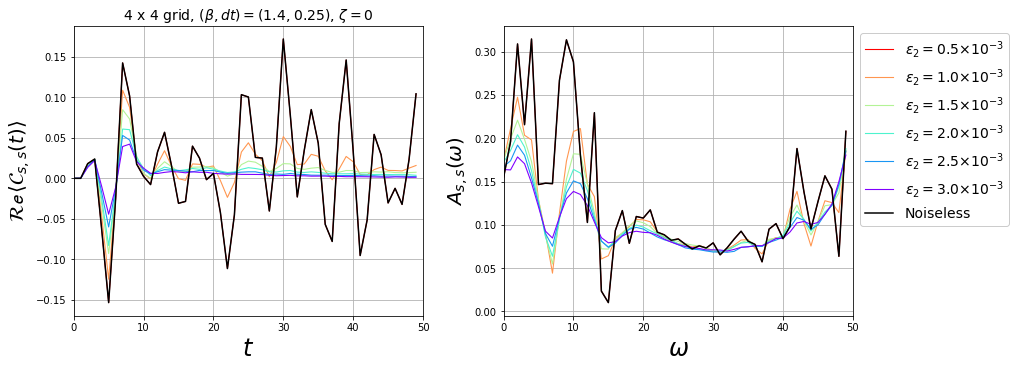

In [79]:
import matplotlib.cm as cm

colors = list(reversed([x for x in cm.rainbow(np.linspace(0, 1, len(eps_sweep) -1 )) ]))
k = 0
beta = beta_sweep[k]
trotter_steps = 50
zeta_idx = 0


fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
# Plot time series
# axes: [beta, dt, trotter_step, n, n]
# slice for dt=0.25, and keep only beta in [1.4, 1.6, 1.8]
for i, eps in enumerate(eps_sweep[1:]):
    y = noisy_data_grid[zeta_idx][i][('obc', n)][k, 0,:,1,1].real
    lab = r"$\epsilon_2=$" + f"{eps * 10**3}" + r"$\times 10^{-3}$"
    axes[0].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)    
# Plot spectrum
for i, eps in enumerate(eps_sweep[1:]):
    y = noisy_fourier_grid[zeta_idx][i][0][('obc', n, 0.25, beta)]
    lab = r"$\epsilon_2=$" + f"{eps * 10**3}" + r"$\times 10^{-3}$"
    axes[1].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)

# OVERLAY NOISELESS
axes[0].plot(noiseless_data[('obc', n)][k, 0,:,1,1].real, label="Noiseless", c='k', lw=1.5)
axes[1].plot(noiseless_fourier[0][('obc', n, 0.25, beta)], label="Noiseless", c='k', lw=1.5)

axes[0].set_title(f"{n} x {n} grid, " + r"$(\beta, dt)= $" + f"({beta}, 0.25), " + r"$\zeta=0$", size=14)

axes[0].set_ylabel(r"$\mathcal{Re}\,\langle \mathcal{C}_{s,s}(t) \rangle$", size=20)
axes[0].set_xlabel(r"$t$", size=24)
axes[1].set_xlabel(r"$\omega$", size=24)
axes[1].set_ylabel(r"$A_{s,s}(\omega) $", size=20)

axes[1].legend(bbox_to_anchor=(1.0, 1), framealpha=1, prop={'size': 14})
for ax in axes:
    ax.grid()
    ax.set_xlim(0, 50)
fig.savefig(f"../figures/sample_n{n}_zeta0_eps_timeseries.pdf")

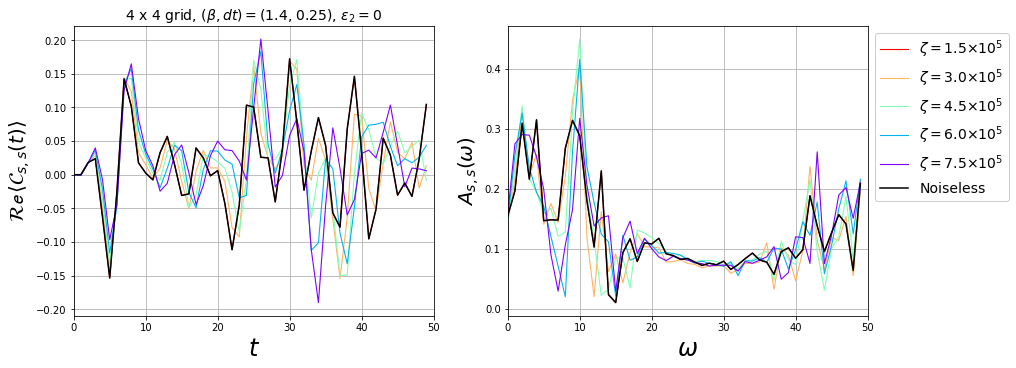

In [80]:
colors = list(reversed([x for x in cm.rainbow(np.linspace(0, 1, len(zeta_sweep)-1)) ]))
k = 0
beta = beta_sweep[k]
trotter_steps = 50
eps_idx = 0


fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
# Plot time series
# axes: [beta, dt, trotter_step, n, n]
# slice for dt=0.25, and keep only beta in [1.4, 1.6, 1.8]
for i, zeta in enumerate(zeta_sweep[1:]):
    y = noisy_data_grid[i][eps_idx][('obc', n)][k, 0,:,1,1].real
    lab = r"$\zeta=$" + f"{zeta / 10**5}" + r"$\times 10^5$"
    axes[0].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)    
# Plot spectrum
for i, zeta in enumerate(zeta_sweep[1:]):
    y = noisy_fourier_grid[i][eps_idx][0][('obc', n, 0.25, beta)]
    lab = r"$\zeta=$" + f"{zeta / 10**5}" + r"$\times 10^5$"
    axes[1].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)

# OVERLAY NOISELESS
axes[0].plot(noiseless_data[('obc', n)][k, 0,:,1,1].real, label="Noiseless", c='k', lw=1.5)
axes[1].plot(noiseless_fourier[0][('obc', n, 0.25, beta)], label="Noiseless", c='k', lw=1.5)

axes[0].set_title(f"{n} x {n} grid, " + r"$(\beta, dt)= $" + f"({beta}, 0.25), " + r"$\epsilon_2=0$", size=14)

axes[0].set_ylabel(r"$\mathcal{Re}\,\langle \mathcal{C}_{s,s}(t) \rangle$", size=20)
axes[0].set_xlabel(r"$t$", size=24)
axes[1].set_xlabel(r"$\omega$", size=24)
axes[1].set_ylabel(r"$A_{s,s}(\omega) $", size=20)

axes[1].legend(bbox_to_anchor=(1.0, 1), framealpha=1, prop={'size': 14})
for ax in axes:
    ax.grid()
    ax.set_xlim(0, 50)
    
fig.savefig(f"../figures/sample_n{n}_zeta_eps0_timeseries.pdf")

### Shared plot!


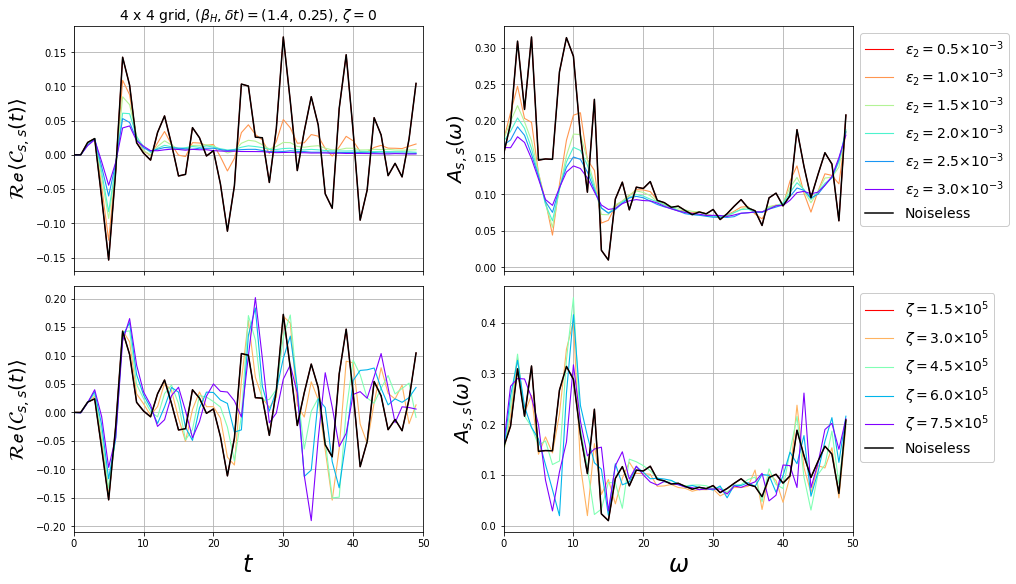

In [95]:

colors = list(reversed([x for x in cm.rainbow(np.linspace(0, 1, len(eps_sweep) -1 )) ]))
k = 0
beta = beta_sweep[k]
trotter_steps = 50
zeta_idx = 0


fig, axes = plt.subplots(2, 2, figsize=(14, 8), constrained_layout=True, sharex=True, sharey=False)
# Plot time series
# axes: [beta, dt, trotter_step, n, n]
# slice for dt=0.25, and keep only beta in [1.4, 1.6, 1.8]
for i, eps in enumerate(eps_sweep[1:]):
    y = noisy_data_grid[zeta_idx][i][('obc', n)][k, 0,:,1,1].real
    lab = r"$\epsilon_2=$" + f"{eps * 10**3}" + r"$\times 10^{-3}$"
    axes[0,0].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)    
# Plot spectrum
for i, eps in enumerate(eps_sweep[1:]):
    y = noisy_fourier_grid[zeta_idx][i][0][('obc', n, 0.25, beta)]
    lab = r"$\epsilon_2=$" + f"{eps * 10**3}" + r"$\times 10^{-3}$"
    axes[0,1].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)

# OVERLAY NOISELESS
axes[0,0].plot(noiseless_data[('obc', n)][k, 0,:,1,1].real, label="Noiseless", c='k', lw=1.5)
axes[0,1].plot(noiseless_fourier[0][('obc', n, 0.25, beta)], label="Noiseless", c='k', lw=1.5)

axes[0,0].set_title(f"{n} x {n} grid, " + r"$(\beta_H, \delta t)= $" + f"({beta}, 0.25), " + r"$\zeta=0$", size=14)

axes[0,0].set_ylabel(r"$\mathcal{Re}\,\langle \mathcal{C}_{s,s}(t) \rangle$", size=20)
# axes[0,0].set_xlabel(r"$t$", size=24)
# axes[0,1].set_xlabel(r"$\omega$", size=24)
axes[0,1].set_ylabel(r"$A_{s,s}(\omega) $", size=20)

axes[0,1].legend(bbox_to_anchor=(1.0, 1), framealpha=1, prop={'size': 14})


colors = list(reversed([x for x in cm.rainbow(np.linspace(0, 1, len(zeta_sweep)-1)) ]))
# axes: [beta, dt, trotter_step, n, n]
# slice for dt=0.25, and keep only beta in [1.4, 1.6, 1.8]
for i, zeta in enumerate(zeta_sweep[1:]):
    y = noisy_data_grid[i][eps_idx][('obc', n)][k, 0,:,1,1].real
    lab = r"$\zeta=$" + f"{zeta / 10**5}" + r"$\times 10^5$"
    axes[1,0].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)    
# Plot spectrum
for i, zeta in enumerate(zeta_sweep[1:]):
    y = noisy_fourier_grid[i][eps_idx][0][('obc', n, 0.25, beta)]
    lab = r"$\zeta=$" + f"{zeta / 10**5}" + r"$\times 10^5$"
    axes[1,1].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)

# OVERLAY NOISELESS
axes[1,0].plot(noiseless_data[('obc', n)][k, 0,:,1,1].real, label="Noiseless", c='k', lw=1.5)
axes[1,1].plot(noiseless_fourier[0][('obc', n, 0.25, beta)], label="Noiseless", c='k', lw=1.5)

axes[1,0].set_ylabel(r"$\mathcal{Re}\,\langle \mathcal{C}_{s,s}(t) \rangle$", size=20)
axes[1,0].set_xlabel(r"$t$", size=24)
axes[1,1].set_xlabel(r"$\omega$", size=24)
axes[1,1].set_ylabel(r"$A_{s,s}(\omega) $", size=20)

axes[1,1].legend(bbox_to_anchor=(1.0, 1), framealpha=1, prop={'size': 14})
for ax in axes.flatten():
    ax.grid()
    ax.set_xlim(0, 50)
    
fig.savefig(f"../figures/sample_n{n}_zeta_eps_timeseries_combined.pdf")

## Bulk analysis

The primary analysis that we can apply en masse is to compare $\Delta E_{01}$ as a function of $dt$ across different noise strengths.

### Start by looking at mass versus dt

The following is less condensed but can maybe reveal trends in the noise behavior.

In [90]:
rel_err_grid = np.zeros((len(beta_sweep), len(zeta_sweep), len(eps_sweep)))
n = 4
dt = 0.25
for i, betakey in enumerate(beta_keys):

    # Plot noiseless energy vs dt
    ens = noiseless_fourier[1]
    noiseless_y = np.abs(np.array(gv.mean(ens[('obc', n, dt, betakey)])))

    for j, zeta in enumerate(zeta_sweep):
        for k, eps in enumerate(eps_sweep):
            ens_noisy = noisy_fourier_grid[j][k][1]

            # Compute and plot absolute error
            noisy_y = np.abs(np.array(gv.mean(ens_noisy[('obc', n, dt, betakey)])))
            noisy_yerr = gv.sdev(ens_noisy[('obc', n, dt, betakey)])

            # Plot relative error
            rel_err = (noisy_y - noiseless_y) / noiseless_y
            rel_err_grid[i,j,k] = rel_err
    rel_err_grid[i,0,0] = 0

In [91]:
rel_err_grid[0]

array([[ 0.        , -0.46824725,  0.0381033 ,  1.        ,  0.71126164,
         1.84674005,  2.03725656],
       [ 0.66553768, -0.62743438, -0.3573243 ,  0.36240474,  1.00508044,
         1.06689246,  1.29212532],
       [ 0.6934801 , -0.59779848, -0.57239627, -0.17442845,  0.22099915,
         0.62743438,  1.08128704],
       [ 0.6934801 , -0.63082134, -0.54530059, -0.35393734,  0.08890771,
         0.0508044 ,  0.43437765],
       [ 0.29889924, -0.56477561, -0.56646909, -0.48094835, -0.19729043,
        -0.21253175,  0.22523285],
       [-0.48179509, -0.51989839, -0.51227773, -0.50804403, -0.3530906 ,
        -0.40897544, -0.16426757]])

In [92]:
rel_err_grid[1]

array([[0.        , 0.06      , 0.1       , 0.08166667, 0.085     ,
        0.105     , 0.11      ],
       [0.        , 0.07      , 0.10166667, 0.10333333, 0.09666667,
        0.09833333, 0.14333333],
       [0.        , 0.075     , 0.08666667, 0.12833333, 0.13333333,
        0.105     , 0.13666667],
       [0.        , 0.06666667, 0.11333333, 0.12666667, 0.12      ,
        0.095     , 0.11166667],
       [0.        , 0.07833333, 0.10833333, 0.105     , 0.12666667,
        0.12666667, 0.155     ],
       [0.        , 0.07666667, 0.10166667, 0.11666667, 0.11833333,
        0.10333333, 0.145     ]])

In [93]:
rel_err_grid[2]

array([[ 0.        , -0.05515588, -0.09352518, -0.13908873, -0.12709832,
        -0.13908873, -0.14748201],
       [-0.01558753, -0.06115108, -0.12110312, -0.13309353, -0.14388489,
        -0.15227818, -0.14508393],
       [-0.01678657, -0.0911271 , -0.13309353, -0.1558753 , -0.15467626,
        -0.1618705 , -0.15947242],
       [-0.04196643, -0.13069544, -0.1618705 , -0.16306954, -0.16546763,
        -0.16786571, -0.15707434],
       [-0.18105516, -0.20863309, -0.20023981, -0.19664269, -0.16306954,
        -0.1882494 , -0.18345324],
       [-0.30815348, -0.25539568, -0.23860911, -0.19664269, -0.18705036,
        -0.19304556, -0.18585132]])

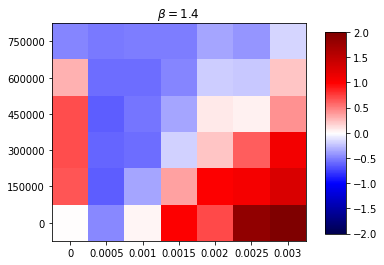

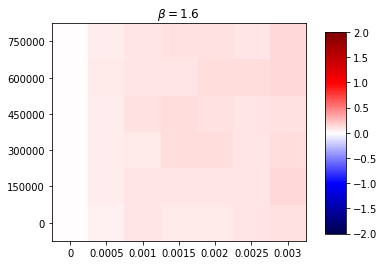

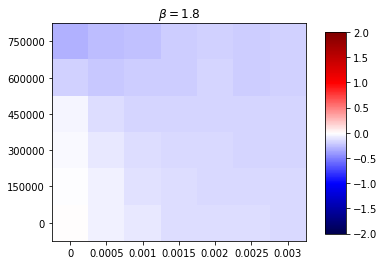

In [94]:
for i, beta in enumerate(beta_sweep):
    fig, ax = plt.subplots()
    im = ax.imshow(rel_err_grid[i], cmap="seismic", vmin=-2, vmax=2, origin='lower')
    ax.set_title(r"$\beta=$" + f"{beta}")
    ax.set_xticks(range(len(eps_sweep)))
    ax.set_xticklabels(eps_sweep)
    ax.set_yticks(range(len(zeta_sweep)))
    ax.set_yticklabels(zeta_sweep)
    
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

### Demo plot

In [25]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

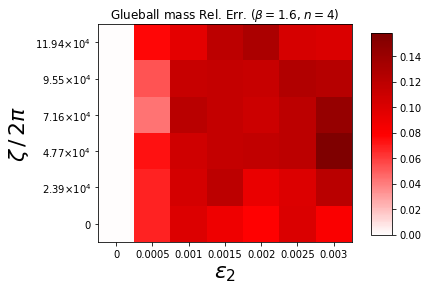

In [26]:
i = 1
beta = beta_sweep[i]
fig, ax = plt.subplots()
cmap = truncate_colormap(plt.get_cmap('seismic'), minval=0.5, maxval=1)
im = ax.imshow(rel_err_grid[i], cmap=cmap, vmin=0, origin='lower')
ax.set_xticks(range(len(eps_sweep)))
ax.set_xticklabels(eps_sweep)
ax.set_yticks(range(len(zeta_sweep)))
zeta_labs = ["0"] + [f"{zeta/(1e4 * np.pi * 2):3.2f}"+r"$\times 10^4$" for zeta in zeta_sweep[1:]]
ax.set_yticklabels(zeta_labs)

betastr = r"$\beta=$"+f"{beta}"
nstr = r"$n=$"+f"{n}"
ax.set_title(f"Glueball mass Rel. Err. ({betastr}, {nstr})")
ax.set_xlabel(r"$\epsilon_2$", size=22)
ax.set_ylabel(r"$\zeta\,/\,2\pi$", size=22)

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
# plt.savefig("../figures/glueball_err_demo.pdf", bbox_inches='tight')

In [ ]:
def plot_timeseries(beta, zetalst, eps_lst)

    colors = list(reversed([x for x in cm.rainbow(np.linspace(0, 1, len(eps_sweep) )) ]))
    k = 1
    beta = beta_sweep[k]
    trotter_steps = 50
    for zeta_idx in [0, -1]:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        # Plot time series
        # axes: [beta, dt, trotter_step, n, n]
        # slice for dt=0.25, and keep only beta in [1.4, 1.6, 1.8]
        for i, eps in enumerate(eps_sweep):
            y = noisy_data_grid[zeta_idx][i][('obc', n)][k, 0,:,1,1].real
            axes[0].plot(range(trotter_steps), y, label=f'{eps}', c=colors[i], alpha=0.7)    
        # Plot spectrum
        for i, eps in enumerate(eps_sweep):
            y = noisy_fourier_grid[zeta_idx][i][0][('obc', 3, 0.25, beta)]
            axes[1].plot(range(trotter_steps), y, label=r"$\epsilon=$" + f'{eps}', c=colors[i], alpha=0.7)

        axes[0].plot(noiseless_data[('obc', 3)][k, 0,:,1,1].real, label="Noiseless", c='k', lw=2)
        axes[1].plot(noiseless_fourier[0][('obc', n, 0.25, beta)], label="Noiseless", c='k', lw=2)

        axes[0].set_ylabel(r"$\langle O_s(t) \rangle$", size=20)
        axes[0].set_xlabel(r"$t$", size=24)
        axes[1].set_xlabel(r"$\omega$", size=24)
        axes[1].set_ylabel(r"$F_O(\omega) $", size=20)

        axes[1].legend(bbox_to_anchor=(1.0, 1), framealpha=1)
        for ax in axes:
            ax.grid()

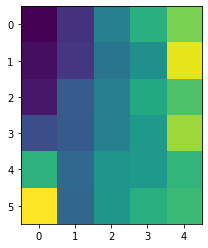

In [22]:
plt.imshow(rel_err_grid[1])

In [16]:
noisy_yerr

0.12566370614359174

[1.28272727]
[1.12681818]
[1.865]
[0.]
[0.]
[0.]
[9.87]
[3.3925]
[0.9025]
[0.]
[0.]
[0.]
[4.24]
[-0.212]
[-0.339]
[-0.016]
[0.]
[0.]


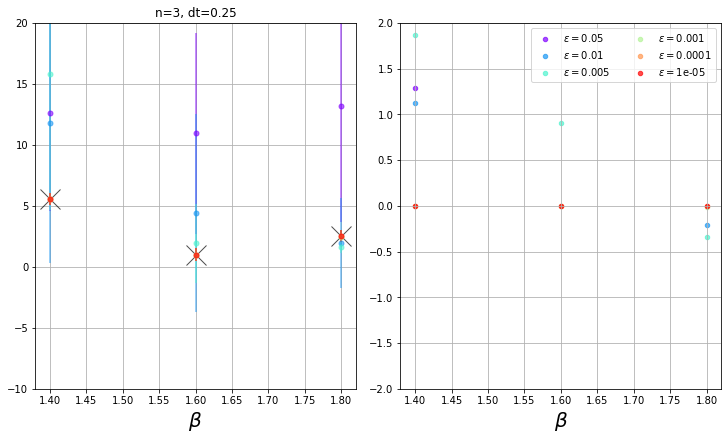

In [92]:
import matplotlib.cm as cm



    
for n in [3]:
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=False)

    # plot params
    s = 20

    for i, betakey in enumerate(beta_keys):
        colors = [x for x in cm.rainbow(np.linspace(0, 1, len(eps_sweep) )) ]
        colors = (x for x in colors)
        
        # Plot noiseless energy vs dt
        ens = noiseless_fourier[1]
        noiseless_y = np.abs(np.array([gv.mean(ens[('obc', n, dt, betakey)]) / dt for dt in dts]))
        noiseless_yerr = gv.sdev([ens[('obc', n, dt, betakey)] / dt for dt in dts])
        axes[0].errorbar(
            betakey, 
            noiseless_y, 
            yerr=noiseless_yerr, 
            fmt='x', 
            label=f"noiseless" if i == 0 else None, 
            markersize=s,
            alpha=0.7,
            c='k'
        )    
        axes[0].set_title(f"n={n}, dt={dt}")

#         for k, zeta in enumerate(zeta_sweep):
        for j, eps in enumerate(eps_sweep):
#             if eps > 0.001:
#                 continue
            c = next(colors)
            ens_noisy = noisy_fourier_grid[0][j][1]

            # Compute and plot absolute error
            noisy_y = np.abs(np.array([gv.mean(ens_noisy[('obc', n, dt, betakey)]) / dt for dt in dts]))
            noisy_yerr = gv.sdev([ens_noisy[('obc', n, dt, betakey)] / dt for dt in dts])
            axes[0].errorbar(
                betakey, 
                noisy_y, 
                yerr=noisy_yerr, 
                fmt='.', 
                label=r"$\epsilon=$" + f"{eps}" if i == 0 else None, 
                markersize=s/2,
                alpha=0.6,
                c=c
            )   
            # Plot relative error
            rel_err = (noisy_y - noiseless_y) / noiseless_y
            print(rel_err)
            axes[1].scatter(
                betakey, 
                rel_err, 
                marker='.', 
                label=r"$\epsilon=$" + f"{eps}" if i == 0 else None, 
                s=80,
                alpha=0.7,
                color=c
            )   


    axes[0].set_ylim(-10, 20)
    axes[0].grid()
    #     ax.semilogy()
    axes[1].set_ylim(-2, 2)
    axes[1].grid()
    for ax in axes:
        ax.set_xlabel(r"$\beta$", size=20)

    axes[1].legend(ncol=2, bbox_to_anchor=(1, 1))


### Noise strength versus $m(t)$

Here we look at a scalar function of $\xi$; I'm going to start with the benchmark quantity

$$
f(\xi) = || m(\Delta t) - m'(\Delta t) ||_2
$$

and the goal is to find
$$
\text{argmax}_\xi  f(\xi) \, s.t. \, f(\xi) \leq \epsilon
$$
where $m(\Delta t)$ is the vector of masses computed from noiseless simulation and $m'$ corresponds to noisy masses. The motivation for $||\cdot ||_2$ is that we need more than a single value of $m$ to run a fit.

 - A possible sticking point will be the inclusion of $\Delta t = 0.01$, which tends to be very sensitive to $\xi$. I'm going to just exclude that point since it seems unrelieable in general

Text(0.5, 0, '$\\zeta$')

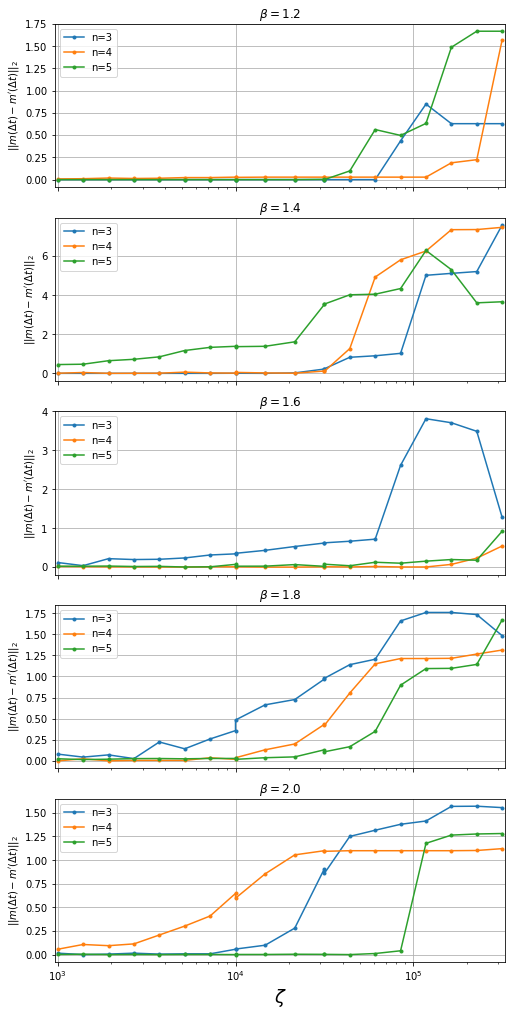

In [40]:
plt.close('all')
dts_trunc = dts[1:]
fig, axes = plt.subplots(len(betas), 1, figsize=(7, 14), constrained_layout=True, sharex=True, sharey=False)

for i, betakey in enumerate(beta_keys):

    for n in [3, 4, 5]:

        ens = noiseless_fourier[1]
        noiseless_y = np.abs(np.array([gv.mean(ens[('obc', n, dt, betakey)]) / dt for dt in dts_trunc]))
        diffs_vs_zeta = []
        zeta_iter = zetas
#         if n == 5:
#             zeta_iter = zetas4
        for j, zeta in enumerate(zeta_iter):
            ens_noisy = noisy_fourier_lst[j][1]
#             if n == 5:
#                 ens_noisy = noisy_fourier_lst_n5[j][1]
            noisy_y = np.abs(np.array([gv.mean(ens_noisy[('obc', n, dt, betakey)]) / dt for dt in dts_trunc]))
            diff_l2 = np.linalg.norm(noiseless_y - noisy_y, ord=2)
            diffs_vs_zeta.append(diff_l2)
        axes[i].plot(zeta_iter, diffs_vs_zeta, label=f"n={n}", marker='.')
        # Consistent across gridsizes
        axes[i].set_xlim(.96*min(zetas), max(zetas)*1.04)
        axes[i].semilogx()
        axes[i].set_ylabel(r"$||m(\Delta t) - m'(\Delta t)||_2$")
        axes[i].set_title(r"$\beta=$" + f"{betakey}")
        axes[i].grid()
        axes[i].legend(loc="upper left")
        
axes[-1].set_xlabel(r"$\zeta$", size=18)
    

In [41]:
len(zetas)

20